# Creating Regions from Uni Coordinates

Using a geojson of the outline of the uk alongside geovoronoi we can split the uk into voronoi regions for each university.

In [1]:
import json

import shapely.ops
import shapely.geometry

import pandas as pd
import geopandas as gpd
from geovoronoi import points_to_coords
from geovoronoi import voronoi_regions_from_coords

import matplotlib.pyplot as plt

In [2]:
outline_file = r'.\uk_outlines\ukoutline.json'
comb_file = r'.\csv\Combined.csv'
output_regions = r'.\regions\voronoi_unis.json'

Load in the outline of the uk along with our University Coordinates.

In [3]:
def load_outline_to_MultiPolygon(filename):
    with open(filename) as f:
        ukoutlinesdata = json.load(f)
    ukoutlinecoords = ukoutlinesdata['features'][0]['geometry']['coordinates']

    polygonlist = []
    for region in ukoutlinecoords:
        # Each region can contain multiple areas of land
        for land in region:
            poly = shapely.geometry.Polygon(land)
            polygonlist.append(poly)

    ukoutline = shapely.geometry.MultiPolygon(polygonlist)

    return ukoutline

In [4]:
ukoutline = load_outline_to_MultiPolygon(outline_file)
unis = pd.read_csv(comb_file) # using combined just cause

ukoutline #This takes ages to display so comment out to skip

In [5]:
# Convert Long and lat to coordinates
coords = []
for index, row in unis.iterrows():
    coords.append([row['Longitude'],row['Latitude']])
coords[0:4]

[[-1.5604252, 52.3793131],
 [-2.0802228, 52.8131677],
 [-1.3949104, 50.9352032],
 [-1.0971748, 50.7944026]]

In [6]:
# Creating Voronoi Regions
# This will take forever
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, ukoutline)

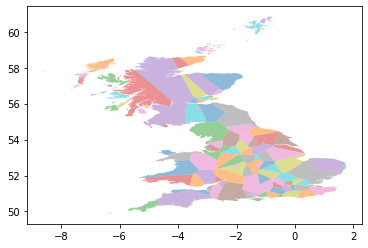

In [7]:
# Displaying regions to check
ge, axs = plt.subplots()
for poly in poly_shapes:
    if isinstance(poly, shapely.geometry.Polygon):
        xs, ys = poly.exterior.xy
        axs.fill(xs,ys, alpha=0.5)
    elif isinstance(poly, shapely.geometry.MultiPolygon):
        for s_poly in poly:
            xs, ys = s_poly.exterior.xy
            axs.fill(xs,ys, alpha=0.5)
plt.show()

You could just use these shapely regions for whatever plotting you need to do but I will export them out to a GeoJSON for greater compatability with other mapping tools.

In [8]:
# Format shapely collection into a GeoJSON
geoJson = gpd.GeoSeries(poly_shapes).__geo_interface__

# Assign the correct name and properties to each region
for index, feature in enumerate(geoJson['features']):
    # Get relevent information using indexing
    poly_to_pt = poly_to_pt_assignments[index]
    if len(poly_to_pt) == 1:
        poly_to_pt = poly_to_pt[0]
    else:
        raise ValueError('Multiple unis in same location')
    pt = pts[poly_to_pt]
    uni_stats = unis.iloc[poly_to_pt]
    
    # Add University details
    for ind, val in uni_stats.iteritems():
        if ind == 'University':
            feature['id'] = val
        else:
            feature['properties'][ind]=val

For some reason when saving, the json format is unable to cope with int64 so we are going to write our own witchcraft encoder that I stole from [here](https://stackoverflow.com/a/57915246).

In [9]:
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [10]:
# Save to file
with open(output_regions,'w') as f:
    json.dump(geoJson, f, cls=NpEncoder)
    
# Read it in and export again to remove and remaining weirdness (idk)
df = gpd.read_file(output_regions)
df.to_file(output_regions, driver='GeoJSON')
df

id  Rank  Total  Spring  Winter  CS:GO  Dota 2  \
0            University of Surrey    18    736     409   327.0    156      55   
1        University of Chichester    53    230     102   128.0     64       0   
2            University of Sussex    35    518     234   284.0     13       9   
3          University of Brighton    28    625     322   303.0     89       0   
4        University of Portsmouth     4   1257     649   608.0    211      73   
..                            ...   ...    ...     ...     ...    ...     ...   
93        Loughborough University    11    866     372   494.0     76      34   
94  University of the Arts London    88      7       0     7.0      0       0   
95     London School of Economics    98      0       0     0.0      0       0   
96         De Montfort University    47    320     124   196.0    157       8   
97   London South Bank University    76     56      24    32.0      1       0   

    FIFA  Hearthstone  League of Legends  Overwatch  Rainbow 6 (USL)  \
0      2            0                284        179               17   
1    149            0                 14          0                0   
2     23           42                 42         86               39   
3      0            0                137          0                3   
4     34            0                174        250               68   
..   ...          ...                ...        ...              ...   
93     0            0                255         33               89   
94     0            0                  0          0                0   
95     0            0                  0          0                0   
96    18            0                103          0               34   
97     0            0                  7          0                0   

    Rocket League  Smash (Singles)  Smash (Teams)  Tekken (UFG)  Pubg Mobile  \
0              43                0              0             0            0   
1               0                0              0             3            0   
2             264                0              0             0            0   
3             141              192             63             0            0   
4             358               79              5             4            1   
..            ...              ...            ...           ...          ...   
93            370                9              0             0            0   
94              0                7              0             0            0   
95              0                0              0             0            0   
96              0                0              0             0            0   
97              0               41              0             7            0   

    Longitude   Latitude                                           geometry  
0   -0.590014  51.243033  POLYGON ((-0.43333 50.92905, -0.52816 50.97288...  
1   -0.774008  50.844940  MULTIPOLYGON (((-0.88233 51.13657, -0.52841 50...  
2   -0.087786  50.867956  MULTIPOLYGON (((-0.42913 50.80381, -0.43333 50...  
3    0.265513  50.755450  POLYGON ((0.07840 50.77886, 0.19447 51.14334, ...  
4   -1.097175  50.794403  MULTIPOLYGON (((-0.98073 51.10829, -0.93912 50...  
..        ...        ...                                                ...  
93  -1.239682  52.762782  MULTIPOLYGON (((-1.12819 52.83021, -1.05540 52...  
94  -0.116403  51.517679  POLYGON ((-0.12671 51.51664, -0.08669 51.61787...  
95  -0.116588  51.514429  MULTIPOLYGON (((-0.13044 51.51033, -0.12671 51...  
96  -1.139843  52.630061  POLYGON ((-1.06947 52.78691, -1.23201 52.37709...  
97  -0.101859  51.497788  MULTIPOLYGON (((-0.13147 51.48642, -0.12533 51...  

[98 rows x 20 columns]

If we then plug this into [flourish](https://flourish.studio/) we get this (with a little bit of messing around with sliders).

https://public.flourish.studio/visualisation/3703549/